## <font color=darkgreen> Compte-rendu de TP classification non-supervisée par Renaud Leurquin et Pablo Piguet </font>

Import des librairies utiles pour le projet :

In [1]:
import pandas as pd 
import matplotlib.pyplot as plt
from sklearn import cluster
from sklearn import metrics
import numpy as np
from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.cluster.hierarchy import fcluster
%matplotlib inline

## <font color=darkred> Livrable 1 : Visualisation des signatures authentiques </font>

La cellule suivante permet de lire chaque fichier signature « .txt » contenant les paramètres acquis par la tablette Wacom lorsque la personne a signé. Nous nommons les colonnes pour pouvoir y accéder par le suite. 

In [2]:
df_test = pd.read_csv('Base de données/43v0.txt', sep=' ')
df_test.columns = ["x","y","P","Az","Al"]
df_test.info()
df_test.head(10)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 875 entries, 0 to 874
Data columns (total 5 columns):
x     875 non-null int64
y     875 non-null int64
P     875 non-null int64
Az    875 non-null int64
Al    875 non-null int64
dtypes: int64(5)
memory usage: 34.3 KB


,x,y,P,Az,Al
0,1086,7934,89,172,59
1,1086,7934,155,172,59
2,1086,7934,226,171,60
3,1086,7934,281,171,60
4,1086,7934,345,171,61
5,1086,7934,382,171,62
6,1086,7934,409,171,62
7,1117,7946,420,168,63
8,1127,7941,443,168,63
9,1141,7941,445,168,63


La cellule suivante permet de visualiser la signature. Comme la tablette Wacom peut faire des acquisitions, même si le stylo est situé à 2cm de la tablette, il faut retirer les lignes dont la valeur de P est nulle (pas de pression du stylo). Le dataframe df_test_cleaned contient toutes les lignes du dataframe original, excepté celles dont la valeur de P est nulle. Puis, il suffit de récupérer les valeurs des coordonnées dans deux listes distinctes et de les tracer. 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 726 entries, 0 to 874
Data columns (total 5 columns):
x     726 non-null int64
y     726 non-null int64
P     726 non-null int64
Az    726 non-null int64
Al    726 non-null int64
dtypes: int64(5)
memory usage: 34.0 KB


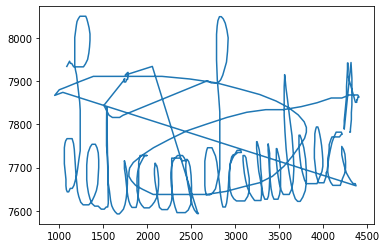

In [3]:
df_test_cleaned = df_test.loc[df_test['P']!=0]
df_test_cleaned.info()

X=df_test_cleaned["x"].values
Y=df_test_cleaned["y"].values

plt.plot(X,Y)

## <font color=darkred> Livrable 2 : Catégoriser les 100 personnes en 3 catégories en se basant sur la complexité moyenne), et cela pour chaque valeur de NG </font>

### <font color=darkblue> Cas 1 : Complexité moyenne calulée avec le modèle GMM à 8 gaussiennes  </font>

La cellule suivante extrait dans un dataframe Pandas les données du fichier texte qui contient la valeur de la mesure de complexité de chacune des 25 signatures appartenant à chacune des 100 personnes. Les deuxième et troisième lignes permettent de remplacer les virgules par des points et de transformer les String en float, dans le but d'avoir des données manipulables arithétiquement. 

In [4]:
df_C8G = pd.read_csv('Complexité avec 8G (100x25).txt', sep='\t', header=None)
df_C8G = df_C8G.stack().str.replace(',','.').unstack()
df_C8G = df_C8G.astype(float)
df_C8G.head(3)

,0,1,2,3,4,5,6,7,8,9,...,15,16,17,18,19,20,21,22,23,24
0,29.089110,28.392300,27.853030,27.777766,25.531894,29.417661,28.029172,30.033364,29.648220,28.563567,...,26.636723,28.016770,27.356955,27.066120,26.817673,26.155769,26.913143,28.372555,28.658760,28.891678
1,27.738042,28.187041,25.196623,26.983445,25.444403,28.020889,28.919264,27.831452,27.918284,27.384083,...,26.579561,27.382084,25.710206,26.764831,26.299805,26.782755,26.307688,27.163276,26.059125,26.338765
2,29.347793,29.762017,29.462618,29.534144,29.097376,30.274486,29.057941,31.046536,29.635312,29.350980,...,29.603737,30.654214,30.552009,30.453519,29.767433,29.601570,30.983488,29.736001,28.897460,30.353071


Remarquons que comme les données ne contiennent qu'une seule feature (la complexité moyenne), il n'est donc pas nécessaire de les normaliser, ce qu'on aurait dû faire avec un z-scoring par exemple si les données contenaient au moins 2 features. Ici, la cellule suivante permet d'itérer sur les lignes du dataframe contenant les données du fichier $Complexité$ $avec$ $8G$. Pour chaque ligne, il est calculé la moyenne de l'ensemble des valeurs de la ligne. On calcule donc la complexité moyenne des 25 signatures de chaque individu, qu'on stocke dans une liste, qu'on transformera ensuite en tableau de type $numpy$ pour être exploitable par sklearn pour les méthodes de clustering.

In [5]:
L8G = []
for index, row in df_C8G.iterrows():
    L8G.append(row.mean())    
arr = np.array(L8G)
arr = arr.reshape(-1,1)

Méthode k-means avec k=3 clusters. Ici, la méthode d'initialisation du centre des clusters 'k-means++' permet de choisir ces centres de façon à accélérer la convergence de l'algorithme. Le paramètre 'n_init' définit le nombre de fois où l'algorithme k-means tournera avec des initialisation des centres des clusters différentes à chaque fois. Le résultat final sera le cluster ayant obtenu les meilleurs résultats en terme d'inertie intra-classe (celui pour lequel l'inertie intra-classe sera minimale). Le paramètre n_jobs=-1 signifie que l'ensemble des ressources de l'ordinateur est utilisée pour le calcul. 

In [6]:
kmeans = cluster.KMeans(n_clusters=3, init='k-means++', n_init=15, n_jobs=-1)
kmeans.fit(arr)


KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=3, n_init=15, n_jobs=-1, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

Nous stockons ici dans des variables les caractéristiques des signatures des personnes dans chaque catégorie (le représnetant de chaque cluster qui est sa moyenne). 

In [7]:
cluster_1 = kmeans.cluster_centers_[0,0]
cluster_2 = kmeans.cluster_centers_[1,0]
cluster_3 = kmeans.cluster_centers_[2,0]

In [8]:
#index triés des groupes
idk = np.argsort(kmeans.labels_)

#création d'un dataframe contenant les complexités moyennes des individus, regroupés par cluster
clusters = pd.DataFrame(arr[idk], index=kmeans.labels_[idk], columns=['Complexité 8G'])
"""
print("Voici les complexités moyennes des signatures de chaque individu, regroupés par catégorie. Les indices O, 1 ou 2 indiquent à quel cluster les individus appartiennent.")
print()
print("Ce tableau nous permettra par la suite de vérifier si nos calculs comme le pourcentage de personnes dans chaque catégorie.")
print()
with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    print(clusters)
"""

#calcul des pourcentages de personnes dans chaque catégorie
gb = clusters.groupby(kmeans.labels_)
nb_clusters = gb.size()
nb_clusters = nb_clusters.values

#calcul du centre des données, utile pour le calcul de l'inertie inter-classe
m = clusters['Complexité 8G'].mean()
s1=0
s2=0
s3=0
for index, data in clusters.iterrows():
    if index == 0 :
        s1+=(data['Complexité 8G']-cluster_1)**2
    if index == 1 :
        s2+=(data['Complexité 8G']-cluster_2)**2
    if index == 2 :
        s3+=(data['Complexité 8G']-cluster_3)**2
I_w = s1+s2+s3
I_b = nb_clusters[0]*((cluster_1-m)**2)+nb_clusters[1]*((cluster_2-m)**2)+nb_clusters[2]*((cluster_3-m)**2)

#création d'un dataframe récapitulatif
print()
print("Le tableau suivant est un tableau récapitulatif. Les 3 premières lignes donnent le pourcentage d'individus dans chaque classe. Par exemple, %cat1=52 signifie que 52% des individus sont dans le groupe 1. Les 3 lignes suivantes indiquent les caractéristiques des signatures des personnes pour chaque catégorie, c'est-à-dire le centre de chaque représentant de chaque cluster. Enfin, les deux dernières lignes représentent l'inertie intra et inter classe.")
arr_stat = np.array([nb_clusters[0], nb_clusters[1], nb_clusters[2],cluster_1, cluster_2, cluster_3, I_w, I_b])
arr_stat.reshape(-1,1)
df_stat = pd.DataFrame(arr_stat, index = ['%cat1', '%cat2', '%cat3', 'centroid 1', 'centroid 2', 'centroid 3', 'inertie intra-classe', 'inertie inter-classe'], columns = ['GMM 8G'])
df_stat



Le tableau suivant est un tableau récapitulatif. Les 3 premières lignes donnent le pourcentage d'individus dans chaque classe. Par exemple, %cat1=52 signifie que 52% des individus sont dans le groupe 1. Les 3 lignes suivantes indiquent les caractéristiques des signatures des personnes pour chaque catégorie, c'est-à-dire le centre de chaque représentant de chaque cluster. Enfin, les deux dernières lignes représentent l'inertie intra et inter classe.


,GMM 8G
%cat1,40.000000
%cat2,52.000000
%cat3,8.000000
centroid 1,30.010458
centroid 2,27.880915
centroid 3,22.687009
inertie intra-classe,50.848206
inertie inter-classe,378.175326


### <font color=darkblue> Cas 2 et 3 : Complexité moyenne calulée avec le modèle GMM à 4 et 24 gaussiennes  </font>

Récupération de la base de données en faisant attention à convertir les valeurs en float.

In [9]:
df_C4G = pd.read_csv('Complexité avec 4G (100x25).txt', sep='\t', header=None)
df_C4G = df_C4G.stack().str.replace(',','.').unstack()
df_C4G = df_C4G.astype(float)

df_C24G = pd.read_csv('Complexité avec 24G (100x25).txt', sep='\t', header=None)

Calcul de la complexité moyenne pour les 25 signatures de chacune des 100 personnes (dans les deux cas). 

In [10]:
L4G = []
for index, row in df_C4G.iterrows():
    L4G.append(row.mean())    
arr1 = np.array(L4G)
arr1 = arr1.reshape(-1,1)

L24G = []
for index, row in df_C24G.iterrows():
    L24G.append(row.mean())    
arr2 = np.array(L24G)
arr2 = arr2.reshape(-1,1)

Exécution de l'algorithme k-means avec 3 clusters.

In [11]:
kmeans1 = cluster.KMeans(n_clusters=3, init='k-means++', n_init=15, n_jobs=-1)
kmeans1.fit(arr1)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=3, n_init=15, n_jobs=-1, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

In [12]:
kmeans2 = cluster.KMeans(n_clusters=3, init='k-means++', n_init=15, n_jobs=-1)
kmeans2.fit(arr2)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=3, n_init=15, n_jobs=-1, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

Récupération des caractéristiques des signatures des personnes pour chaque catégorie.

In [13]:
cluster_4 = kmeans1.cluster_centers_[0,0]
cluster_5= kmeans1.cluster_centers_[1,0]
cluster_6 = kmeans1.cluster_centers_[2,0]

cluster_7 = kmeans2.cluster_centers_[0,0]
cluster_8= kmeans2.cluster_centers_[1,0]
cluster_9 = kmeans2.cluster_centers_[2,0]

In [14]:
#index triés des groupes
idk1 = np.argsort(kmeans1.labels_)

#création d'un dataframe contenant les complexités moyennes des individus, regroupés par cluster
clusters1 = pd.DataFrame(arr1[idk1], index=kmeans1.labels_[idk1], columns=['Complexité 4G'])

#calcul des pourcentages de personnes dans chaque catégorie
gb1 = clusters1.groupby(kmeans1.labels_)
nb_clusters1 = gb1.size()
nb_clusters1 = nb_clusters1.values

#calcul du centre des données, utile pour le calcul de l'inertie inter-classe
m1 = clusters1['Complexité 4G'].mean()

#calcul des inerties intra et inter classe
s4=0
s5=0
s6=0
for index, data in clusters1.iterrows():
    if index == 0 :
        s4+=(data['Complexité 4G']-cluster_4)**2
    if index == 1 :
        s5+=(data['Complexité 4G']-cluster_5)**2
    if index == 2 :
        s6+=(data['Complexité 4G']-cluster_6)**2
        
#inertie intra-classe       
I_w1 = s4+s5+s6
#inertie inter-classe       
I_b1 = nb_clusters1[0]*((cluster_4-m1)**2)+nb_clusters1[1]*((cluster_5-m1)**2)+nb_clusters1[2]*((cluster_6-m1)**2)


arr_stat1 = np.array([nb_clusters1[0], nb_clusters1[1], nb_clusters1[2],cluster_4, cluster_5, cluster_6, I_w1, I_b1])
arr_stat1.reshape(-1,1)
df_stat['GMM 4G'] = arr_stat1
df_stat = df_stat.reindex(columns = ['GMM 4G', 'GMM 8G'])



In [15]:
#index triés des groupes
idk2 = np.argsort(kmeans2.labels_)

#création d'un dataframe contenant les complexités moyennes des individus, regroupés par cluster
clusters2 = pd.DataFrame(arr2[idk2], index=kmeans2.labels_[idk2], columns=['Complexité 24G'])
"""
with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    print("Voici les complexités moyennes des signatures de chaque individu (GMM 4G), regroupés par catégorie. Les indices O, 1 ou 2 indiquent à quel cluster les individus appartiennent.")
    print()
    print(clusters1)
    print()
    print("//////////////////////////////////////////////////////////////////")
    print()
    print("Voici les complexités moyennes des signatures de chaque individu (GMM 24G), regroupés par catégorie. Les indices O, 1 ou 2 indiquent à quel cluster les individus appartiennent.")
    print()
    print(clusters2) 
"""

#calcul des pourcentages de personnes dans chaque catégorie
gb2 = clusters2.groupby(kmeans2.labels_)
nb_clusters2 = gb2.size()
nb_clusters2 = nb_clusters2.values

#calcul du centre des données, utile pour le calcul de l'inertie inter-classe
m2 = clusters2['Complexité 24G'].mean()

#calcul des inerties intra et inter classe
s7=0
s8=0
s9=0
for index, data in clusters2.iterrows():
    if index == 0 :
        s7+=(data['Complexité 24G']-cluster_7)**2
    if index == 1 :
        s8+=(data['Complexité 24G']-cluster_8)**2
    if index == 2 :
        s9+=(data['Complexité 24G']-cluster_9)**2
        
#inertie intra-classe       
I_w2 = s7+s8+s9
#inertie inter-classe       
I_b2 = nb_clusters2[0]*((cluster_7-m2)**2)+nb_clusters2[1]*((cluster_8-m2)**2)+nb_clusters2[2]*((cluster_9-m2)**2)


arr_stat2 = np.array([nb_clusters2[0], nb_clusters2[1], nb_clusters2[2],cluster_7, cluster_8, cluster_9, I_w2, I_b2])
arr_stat2.reshape(-1,1)
df_stat['GMM 24G'] = arr_stat2
print()
print()
print("Tableau récapitulatif final :")
print()
df_stat



Tableau récapitulatif final :



,GMM 4G,GMM 8G,GMM 24G
%cat1,40.000000,40.000000,45.000000
%cat2,42.000000,52.000000,7.000000
%cat3,18.000000,8.000000,48.000000
centroid 1,29.763118,30.010458,23.058865
centroid 2,31.386733,27.880915,11.655480
centroid 3,27.811652,22.687009,26.835033
inertie intra-classe,30.081946,50.848206,183.043795
inertie inter-classe,168.331970,378.175326,1491.828248


Interprétation : Nous pouvons remarquer que pour les modèles GMM 4G et GMM 8G, la valeur du représentant du premier cluster est quasi identique (27.811652 et 27.880915). Deux clusters sont donc identiques pour ces deux modélisations différentes. En revanche, 18% des individus sont dans ce cluster pour le modèle GMM 4G, alors que 52% des individus le sont pour le modèle GMM 8G, ce qui est assez étonnant. Cela montre l'importance de la modélisation qui influe beaucoup sur la qualité du partitionnement. 
De façon générale dans les 3 modélisations différentes, on observe qu'un des clusters a un nombre d'individus moins élevé que les deux autres. 

De plus, nous remarquons que plus le nombre de gaussiennes utilisées est grand, plus l'inertie intra-classe et inter-classe est élevé. 

### <font color=darkblue> Nous refaisons le même travail avec la méthode CAH de Classification ascendante hiérarchique  </font>

### <font color=darkblue>Cas 1 : CAH avec le modèle GMM 4G :  </font>

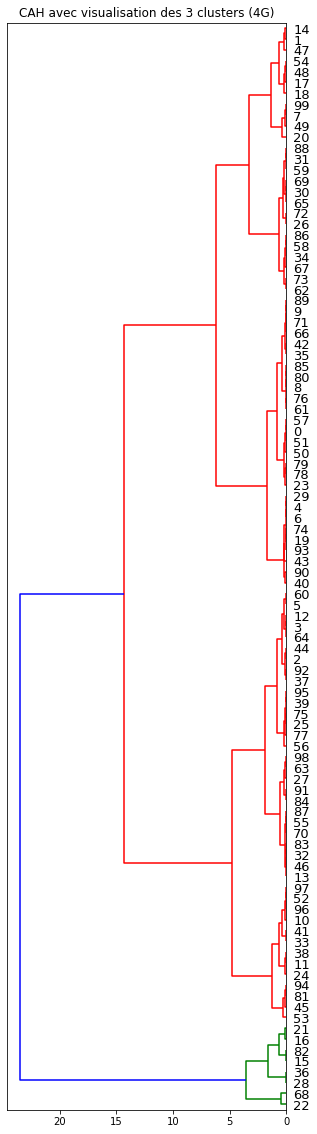

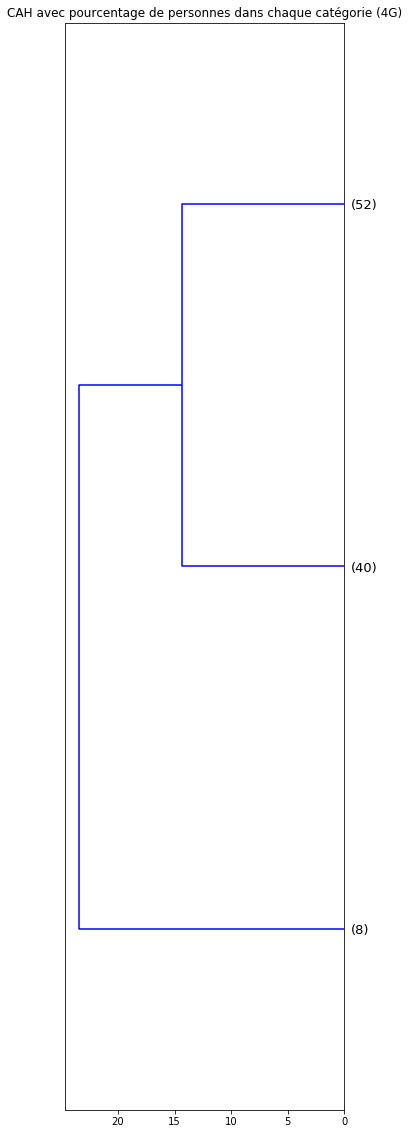

In [16]:
index=np.arange(0,100,1)

df_C4G = pd.read_csv('Complexité avec 4G (100x25).txt', sep='\t', header=None)
df_C4G = df_C8G.astype(float)

L4G = []
for index, row in df_C8G.iterrows():
    L4G.append(row.mean())    
arr = np.array(L4G)
arr = arr.reshape(-1,1)

list_moy=[]
for i in range(len(L4G)):
    list_moy.append(L4G[i])


fig = plt.figure(1, figsize=(5, 20))
Z = linkage(arr,method='ward',metric='euclidean')
plt.title("CAH avec visualisation des 3 clusters (4G)")
dendrogram(Z,orientation='left',color_threshold=20, leaf_font_size=13)
plt.show()

#grâce à la commande color_threshold on visualise nos 3 clusters

fig = plt.figure(1, figsize=(5, 20))
Z = linkage(arr,method='ward',metric='euclidean')
plt.title("CAH avec pourcentage de personnes dans chaque catégorie (4G)")
dendrogram(Z,orientation='left',color_threshold=0, leaf_font_size=13, truncate_mode='lastp', p=3)
plt.show()

index=np.arange(0,100,1)

groupes_cah = fcluster(Z,t=20,criterion='distance')
idg = np.argsort(groupes_cah)

data={'id_individu':index[idg],'cluster':groupes_cah[idg]}
df=pd.DataFrame(data)


#print(df.to_string())


### <font color=darkblue>Cas 2 : CAH avec le modèle GMM 8G :  </font>

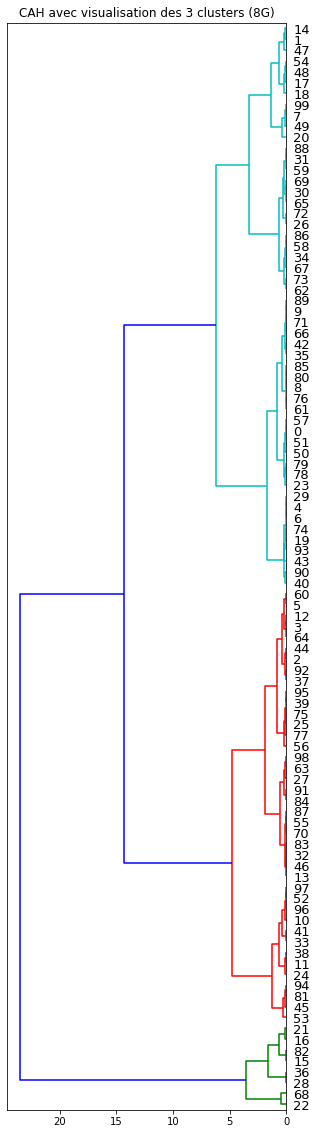

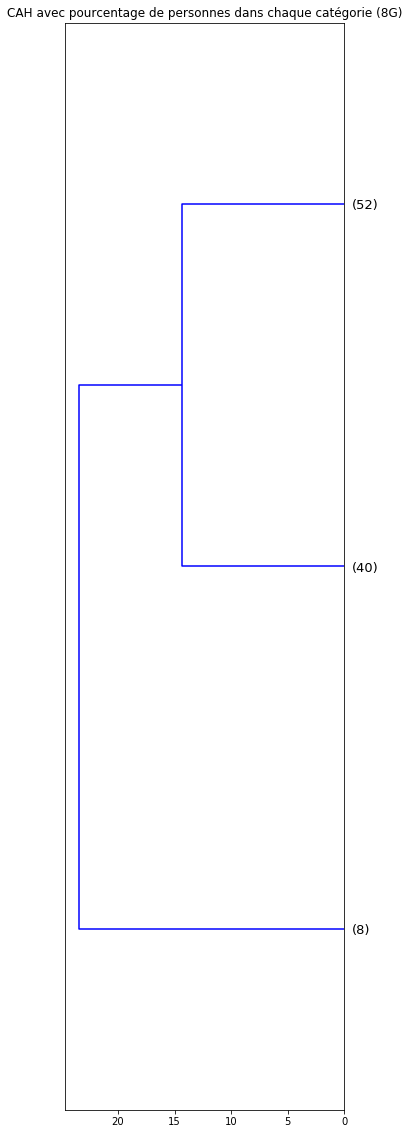

In [17]:
moy=[[0, 28.13632421], [1, 27.02774981], [2, 29.78863293], [3, 29.70340756], [4, 28.82226094], [5, 29.56389794], [6, 28.80625951], [7, 26.45299376], [8, 28.29591222], [9, 28.52292219], [10, 30.68842415], [11, 30.44124655], [12, 29.69353707], [13, 29.40970808], [14, 27.12909339], [15, 22.0376821], [16, 21.68723421], [17, 26.89028473], [18, 26.68305916], [19, 28.78523583], [20, 26.09318847], [21, 21.57395945], [22, 23.99742526], [23, 28.0248726], [24, 30.38080699], [25, 30.01133026], [26, 27.42403914], [27, 29.12669284], [28, 22.83964365], [29, 28.82807337], [30, 27.66427467], [31, 27.5596595], [32, 29.43686319], [33, 30.86912787], [34, 27.76520225], [35, 28.44846489], [36, 22.85131044], [37, 29.86867344], [38, 30.43739287], [39, 29.99412268], [40, 28.73111458], [41, 30.86583204], [42, 28.43024898], [43, 28.93241077], [44, 29.81506932], [45, 31.04266032], [46, 29.44605101], [47, 27.23637445], [48, 26.77423942], [49, 26.36172588], [50, 28.23133143], [51, 28.17254509], [52, 30.62942426], [53, 31.31050671], [54, 26.81333128], [55, 29.47694849], [56, 30.18800714], [57, 28.13850349], [58, 27.74916277], [59, 27.51571233], [60, 29.6180339], [61, 28.33412024], [62, 27.87442561], [63, 29.20006637], [64, 29.72971887], [65, 27.61650216], [66, 28.49347128], [67, 27.81440714], [68, 24.41919237], [69, 27.65113449], [70, 29.50479115], [71, 28.5451868], [72, 27.45954071], [73, 27.91090398], [74, 28.7851477], [75, 30.02264365], [76, 28.33082623], [77, 30.06406553], [78, 28.09640179], [79, 28.08162546], [80, 28.3124199], [81, 31.11061863], [82, 22.08962361], [83, 29.43050544], [84, 29.30066135], [85, 28.31248327], [86, 27.73669893], [87, 29.46154753], [88, 27.5717137], [89, 28.51968191], [90, 28.66225943], [91, 29.30835191], [92, 29.87926876], [93, 28.7797332], [94, 31.16451934], [95, 29.97174009], [96, 30.60882316], [97, 30.64319484], [98, 29.21142486], [99, 26.47230178]]
moy2=moy

for i in range(len(moy2)):
    del (moy2[i][0])

index=np.arange(0,100,1)

fig = plt.figure(1, figsize=(5, 20))
Z = linkage(moy2,method='ward',metric='euclidean')
plt.title("CAH avec visualisation des 3 clusters (8G)")
dendrogram(Z,orientation='left',color_threshold=7, leaf_font_size=13)
plt.show()

#grâce à la commande color_threshold on visualise nos 3 clusters

fig = plt.figure(1, figsize=(5, 20))
Z = linkage(moy2,method='ward',metric='euclidean')
plt.title("CAH avec pourcentage de personnes dans chaque catégorie (8G)")
dendrogram(Z,orientation='left',color_threshold=0, leaf_font_size=13, truncate_mode='lastp', p=3)
plt.show()


groupes_cah = fcluster(Z,t=7,criterion='distance')
idg = np.argsort(groupes_cah)

#print(groupes_cah[idg])

data={'id_individu':index[idg],'cluster':groupes_cah[idg]}
df=pd.DataFrame(data)

#print(df.to_string())

### <font color=darkblue>Cas 3 : CAH avec le modèle GMM 24G :  </font>

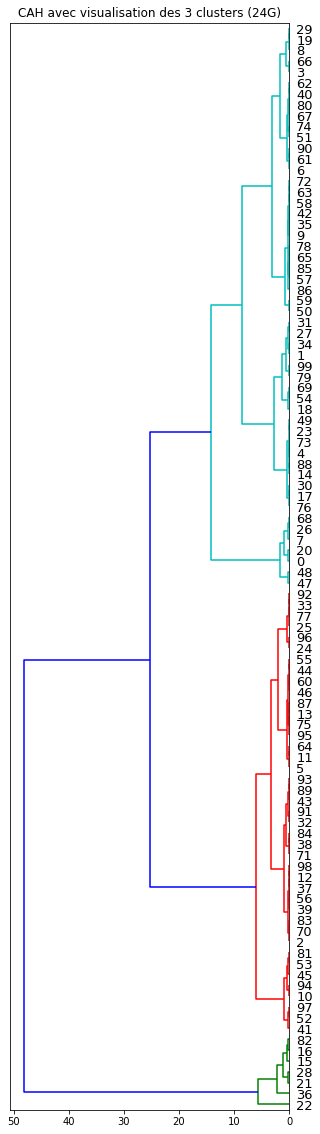

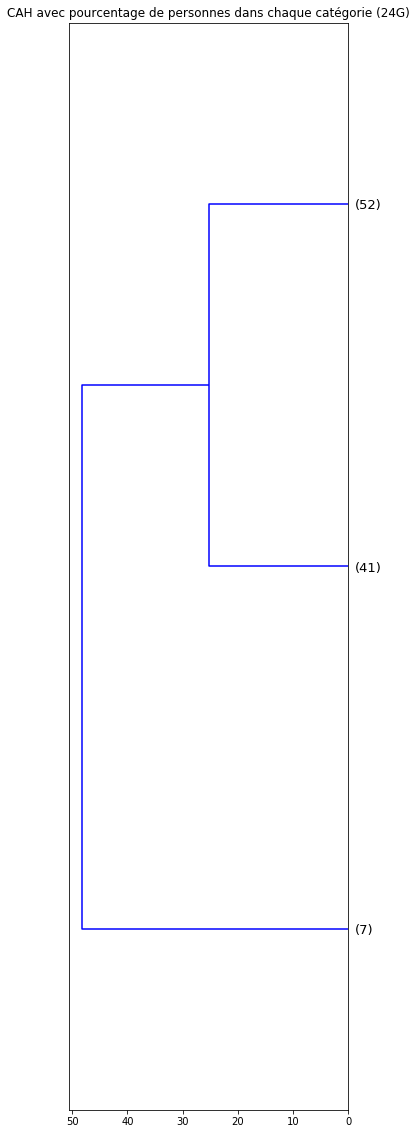

In [18]:
index=np.arange(0,100,1)

df_C8G = pd.read_csv('Complexité avec 24G (100x25).txt', sep='\t', header=None)
df_C8G = df_C8G.astype(float)

L8G = []
for index, row in df_C8G.iterrows():
    L8G.append(row.mean())    
arr = np.array(L8G)
arr = arr.reshape(-1,1)

list_moy=[]
for i in range(len(L8G)):
    list_moy.append(L8G[i])



fig = plt.figure(1, figsize=(5, 20))
Z = linkage(arr,method='ward',metric='euclidean')
plt.title("CAH avec visualisation des 3 clusters (24G)")
dendrogram(Z,orientation='left',color_threshold=20, leaf_font_size=13)
plt.show()

#grâce à la commande color_threshold on visualise nos 3 clusters

fig = plt.figure(1, figsize=(5, 20))
Z = linkage(arr,method='ward',metric='euclidean')
plt.title("CAH avec pourcentage de personnes dans chaque catégorie (24G)")
dendrogram(Z,orientation='left',color_threshold=0, leaf_font_size=13, truncate_mode='lastp', p=3)
plt.show()

index=np.arange(0,100,1)

groupes_cah = fcluster(Z,t=20,criterion='distance')
idg = np.argsort(groupes_cah)

data={'id_individu':index[idg],'cluster':groupes_cah[idg]}
df=pd.DataFrame(data)


#print(df.to_string())

Les trois clusters ont des résultats lisibles directement sur les graphes. 

### <font color=darkblue> Etude du nombre optimal de clusters :  </font>

L'approche est la suivante : nous faisons varier le nombre de groupes entre 2 et 10 et nous observons l'évolution d'un indicateur de qualité de la partition obtenue : le coefficient de silhouette. 

Pour chaque point, on calcule la différence entre la distance moyenne avec les points des autres groupes voisins (Between cluster) et la distance moyenne avec les points du même groupe que lui (withincluster). Ensuite, le coefficient de silhouette est obtenu en divisant cette différence par le maximum entre le Between cluster et le withincluster (pour normaliser ce coefficient). 

Remarque : Si le coefficient est négatif, le point est en moyenne plus proche du groupe voisin que du sien : il est donc mal classé. A l'inverse, si le coefficient est positif, le point est en moyenne plus proche de son groupe que du groupe voisin : il est donc bien classé.

Ici, le résultat obtenu est la moyenne de ces coefficients sur l'ensemble des points considérés. 

Le but est donc de maximiser cette valeur, ce qui signifie :
- maximiser la variance entre les clusters, c'est-à-dire avec des clusters les plus éloignés les uns des autres ;
- minimiser la variance à l'intérieur d'un même cluster, c'est-à-dire avec des individus les plus similaires possibles à l'intérieur d'un même cluster. 

### <font color=darkblue> Etude du nombre optimal de clusters pour le modèle GMM 4G :  </font>

[0.55390758 0.56729091 0.5658519  0.59531349 0.59060719 0.60597843
 0.5952162  0.59239465 0.60914727]


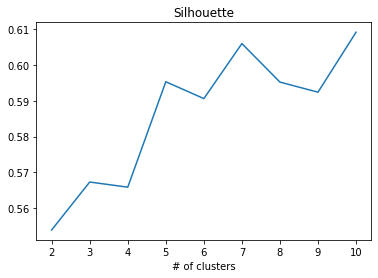

In [19]:
#Mesure du coefficient de silhouette
#En faisant varier le nombre de clusters de 2 à 10
res = np.arange(9,dtype="double")
for k in np.arange(9):
    km = cluster.KMeans(n_clusters=k+2)
    km.fit(arr1)
    res[k] = metrics.silhouette_score(arr1, km.labels_)
print(res)

#tracer
plt.title("Silhouette") 
plt.xlabel("# of clusters") 
plt.plot(np.arange(2,11,1),res) 
plt.show()

On observe que globalement, plus le nombre de clusters augmente, plus le coefficient de silhouette est élevé et donc meilleur sera la partition des données. Le nombre de clusters pour une partition optimale est donc 10. 

### <font color=darkblue> Etude du nombre optimal de clusters pour le modèle GMM 8G :  </font>

[0.79098329 0.6107493  0.62190317 0.61834383 0.63961791 0.63551726
 0.6236645  0.59828988 0.59619381]


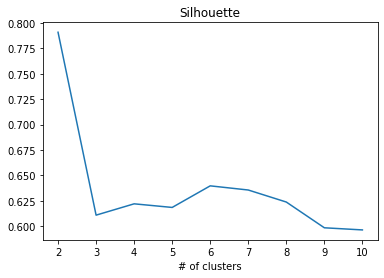

In [20]:
#Mesure du coefficient de silhouette
#En faisant varier le nombre de clusters de 2 à 10
res = np.arange(9,dtype="double")
for k in np.arange(9):
    km = cluster.KMeans(n_clusters=k+2)
    km.fit(arr)
    res[k] = metrics.silhouette_score(arr, km.labels_)
print(res)

#tracer
plt.title("Silhouette") 
plt.xlabel("# of clusters") 
plt.plot(np.arange(2,11,1),res) 
plt.show()

On observe que le coefficient de silhouette diminue fortement lorsqu'il varie de 2 à 4. Puis il remonte progressivement. Le nombre de clusters pour une partition optimale est donc 2. 

### <font color=darkblue> Etude du nombre optimal de clusters pour le modèle GMM 24G :  </font>

[0.79098329 0.60164824 0.62190317 0.61834383 0.63961791 0.63551726
 0.6236645  0.59788299 0.57730131]


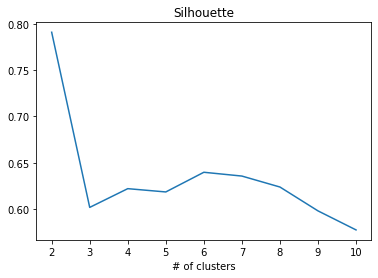

In [21]:
#Mesure du coefficient de silhouette
#En faisant varier le nombre de clusters de 2 à 10
res = np.arange(9,dtype="double")
for k in np.arange(9):
    km = cluster.KMeans(n_clusters=k+2)
    km.fit(arr2)
    res[k] = metrics.silhouette_score(arr2, km.labels_)
print(res)

#tracer
plt.title("Silhouette") 
plt.xlabel("# of clusters") 
plt.plot(np.arange(2,11,1),res) 
plt.show()

De la même manière que pour un nombre de gaussiennes égal à 8, nous observons que le coefficient de silhouette diminue fortement lorsqu'il varie de 2 à 3. Puis il remonte progressivement. Le nombre de clusters pour une partition optimale est donc 2. 

En comparaison, la partition avec le coefficient de silhouette le plus élevé est obtenu pour une mesure de la complexité basée sur une modélisation statistique des signatures par un modèle à mélange de 24 gaussiennes couplée à la mesure d’Entropie Différentielle. Nous pouvons voir que la modélation à 4 gaussiennes donne lieu à un mauvais partitionnement lorsque le nombre de clusters est de 3 (silhouette=0.56729091), alors que les modèles à 8 gaussiennes et 24 gaussiennes donnent lieu à des partitionnements bien meilleurs (silhouette respectivement égales à 0.61519309 et 0.60164824). 

Pour catégoriser ces signatures selon 3 groupes, le meilleur modèle est donc celui à 8 gaussiennes. 